For demo, see the throw.ipynb

Autoformer

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, df, context_length, prediction_length, lags_sequence):
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.lags_sequence = lags_sequence
        self.max_lag = max(lags_sequence)
        self.required_past_length = context_length + self.max_lag

        self.values = df['requests'].values
        self.features = df[['memory', 'cpu']].values

        self.length = len(df) - self.required_past_length - prediction_length + 1

        self.static_real = np.array([df['cpu'].mean(), df['memory'].mean()])
        self.static_cat = np.array([0])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        past_values = self.values[idx : idx + self.required_past_length]
        past_time_features = self.features[idx : idx + self.required_past_length]

        future_values = self.values[
            idx + self.required_past_length : idx + self.required_past_length + self.prediction_length
        ]
        future_time_features = self.features[
            idx + self.required_past_length : idx + self.required_past_length + self.prediction_length
        ]

        past_observed_mask = ~np.isnan(past_values)
        future_observed_mask = ~np.isnan(future_values)

        return {
            'past_values': torch.tensor(past_values, dtype=torch.float),
            'past_time_features': torch.tensor(past_time_features, dtype=torch.float),
            'past_observed_mask': torch.tensor(past_observed_mask, dtype=torch.float),
            'future_values': torch.tensor(future_values, dtype=torch.float),
            'future_time_features': torch.tensor(future_time_features, dtype=torch.float),
            'future_observed_mask': torch.tensor(future_observed_mask, dtype=torch.float),
            'static_real_features': torch.tensor(self.static_real, dtype=torch.float),
            'static_categorical_features': torch.tensor(self.static_cat, dtype=torch.long),
        }


In [3]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

In [4]:
lags_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # can include 0 if needed
context_len = 10  # 21 - max(lags_seq)
prediction_len = 1


In [5]:
dataset = TimeSeriesWindowDataset(df, context_length=context_len, prediction_length=prediction_len, lags_sequence=lags_seq)

In [6]:
loader = DataLoader(dataset, batch_size=64, shuffle=True)
for batch in loader:
    print("past values:", batch['past_values'].shape, end="\n")  
    print("past_time_features: ",batch['past_time_features'].shape, end="\n") 
    print("past_observed_mask: ",batch['past_observed_mask'].shape, end="\n")
    print("future_values: ",batch['future_values'].shape, end="\n") 
    print("future_time_series: ",batch['future_time_features'].shape, end="\n") 
    print("future_observed_mask: ",batch['future_observed_mask'].shape, end="\n") 
    break


past values: torch.Size([64, 20])
past_time_features:  torch.Size([64, 20, 2])
past_observed_mask:  torch.Size([64, 20])
future_values:  torch.Size([64, 1])
future_time_series:  torch.Size([64, 1, 2])
future_observed_mask:  torch.Size([64, 1])


MODEL CONFIGURATION

In [7]:
from transformers import AutoformerForPrediction, AutoformerConfig
config = AutoformerConfig(
    context_length=context_len,
    prediction_length=prediction_len,
    lags_sequence=lags_seq,
    input_size=1,
    num_time_features=2,
    static_categorical_cardinalities=[1],
    static_real_features=2,
)

model = AutoformerForPrediction(config)

/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50  #

Training Part

In [10]:
model.train()
for epoch in range(10):
    total_loss = 0
    for batch in loader:
        # Move batch tensors to the same device as model
        batch = {k: v.to(device) for k, v in batch.items()}

        output = model(
            past_values=batch['past_values'],
            past_time_features=batch['past_time_features'],
            past_observed_mask=batch['past_observed_mask'],
            future_values=batch['future_values'],
            future_time_features=batch['future_time_features'],
            # static_real_features=batch['static_real_features'],
            # static_categorical_features=batch['static_categorical_features']
        )

        loss = output.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

Epoch 1/50, Loss: 19730755.9569
Epoch 2/50, Loss: 64.5831
Epoch 3/50, Loss: 65.6452
Epoch 4/50, Loss: 65.5035
Epoch 5/50, Loss: 62.5815
Epoch 6/50, Loss: 62.8095
Epoch 7/50, Loss: 62.9623
Epoch 8/50, Loss: 66.5178
Epoch 9/50, Loss: 37881.5853
Epoch 10/50, Loss: 62.5133


Evaluation Part

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


def evaluate_forecast(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'MSE': round(mse, 4),
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'R2': round(r2, 4)
    }

Evaluation on a single batch

In [12]:
model.eval()

# Grab a batch
for batch in loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    break

# Generate predictions
with torch.no_grad():
    outputs = model.generate(
        past_values=batch['past_values'],
        past_time_features=batch['past_time_features'],
        past_observed_mask=batch['past_observed_mask'],
        future_time_features=batch['future_time_features'],
        # static_real_features=batch['static_real_features'],  # if you're using these
        # static_categorical_features=batch['static_categorical_features'],
    )

normalized_forecast = outputs.sequences  

loc = batch['past_values'].mean(dim=1, keepdim=True).unsqueeze(-1)   # [B, 1, 1]
scale = batch['past_values'].std(dim=1, keepdim=True).unsqueeze(-1)  # [B, 1, 1]

scale[scale == 0] = 1.0

rescaled_forecast = normalized_forecast * scale + loc

first_pred = rescaled_forecast[:, 0, :]  # [batch_size, 1]
true_values = batch['future_values']


true_values.cpu()
first_pred.cpu()
# print("Ground truth:\n", true_values)
print("First-step Prediction:\n", first_pred)

First-step Prediction:
 tensor([[ 8.1321e+01],
        [ 2.5170e+01],
        [ 4.0250e+01],
        [ 1.5184e+02],
        [ 2.3243e+02],
        [ 2.0758e+00],
        [ 2.4604e+02],
        [ 1.5220e+02],
        [ 1.0321e+02],
        [ 8.0437e+01],
        [ 1.5947e+02],
        [ 2.7297e+01],
        [ 1.0150e+02],
        [ 8.7532e+00],
        [ 4.8201e+01],
        [ 1.2990e+01],
        [ 1.0900e+01],
        [ 3.9105e+01],
        [ 2.4028e+01],
        [ 9.8450e+01],
        [ 7.3175e+01],
        [-1.4168e+00],
        [ 6.0945e+00],
        [ 2.1414e+02],
        [-7.7939e+01],
        [ 7.4058e+01],
        [ 3.0362e+01],
        [ 2.1478e+00],
        [ 5.1992e+01],
        [ 2.2167e+01],
        [ 9.4516e+01],
        [ 7.8686e+01],
        [ 1.5584e+02],
        [ 7.8070e+01],
        [ 4.6315e+00],
        [ 1.2948e+00],
        [ 7.5079e+01],
        [ 9.1310e+01],
        [ 5.7869e+01],
        [ 1.0503e+01],
        [ 1.3365e+02],
        [ 1.3287e+02],
        [ 

Evaluation on entire dataset

In [37]:
model.eval()
all_y_true = []
all_y_pred = []

with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model.generate(
            past_values=batch['past_values'],
            past_time_features=batch['past_time_features'],
            past_observed_mask=batch['past_observed_mask'],
            future_time_features=batch['future_time_features'],
        )

        normalized_forecast = outputs.sequences

        loc = batch['past_values'].mean(dim=1, keepdim=True).unsqueeze(-1)
        scale = batch['past_values'].std(dim=1, keepdim=True).unsqueeze(-1)
        scale[scale == 0] = 1.0

        rescaled_forecast = normalized_forecast * scale + loc
        first_pred = rescaled_forecast[:, 0, :]  # First-step forecast

        all_y_true.append(batch['future_values'].cpu().numpy())
        all_y_pred.append(first_pred.cpu().numpy())

# Flatten all results
y_true = np.concatenate(all_y_true).flatten()
y_pred = np.concatenate(all_y_pred).flatten()

# Evaluate
metrics = evaluate_forecast(y_true, y_pred)
print("Evaluation Metrics (on full dataset):", metrics)


Evaluation Metrics (on full dataset): {'MSE': 7155.0371, 'RMSE': 84.5875, 'MAE': 59.1159, 'R2': -119.755}


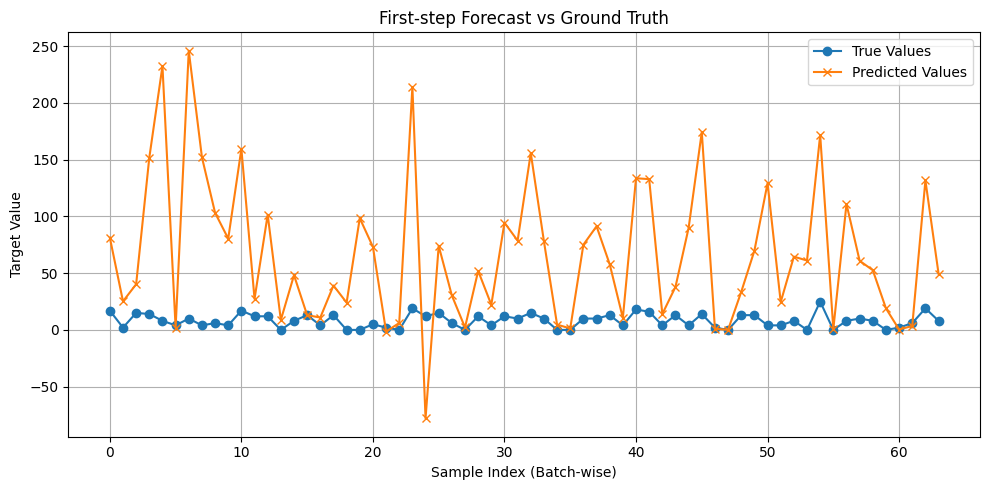

In [15]:
import matplotlib.pyplot as plt

#single batch plotting
y_true = true_values.cpu().numpy().flatten()
y_pred = first_pred.cpu().numpy().flatten()

# entire dataset
# y_true = y_true.flatten()
# y_pred = y_pred.flatten()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_true, label="True Values", marker='o')
plt.plot(y_pred, label="Predicted Values", marker='x')
plt.title("First-step Forecast vs Ground Truth")
plt.xlabel("Sample Index (Batch-wise)")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### INITIAL MODEL CONFIGURATION

In [41]:
output = model.forward(
    past_values=batch['past_values'],
    past_time_features=batch['past_time_features'],
    past_observed_mask=batch['past_observed_mask'],
    future_values=batch['future_values'],
    future_time_features=batch['future_time_features']
)

In [42]:
loss = output.loss

In [43]:
loss.backward()

In [44]:
outputs = model.generate(
    past_values=batch['past_values'],
    past_time_features=batch['past_time_features'],
    past_observed_mask=batch['past_observed_mask'],
    future_time_features=batch['future_time_features']
)

In [45]:
outputs.sequences

tensor([[[25.6606],
         [ 3.5518],
         [15.7382],
         ...,
         [16.0798],
         [11.3151],
         [ 6.9202]],

        [[13.4629],
         [-3.9570],
         [-6.3481],
         ...,
         [ 8.5148],
         [ 7.9559],
         [12.4540]],

        [[10.8084],
         [ 8.4406],
         [10.0167],
         ...,
         [ 7.2567],
         [20.4068],
         [11.1153]],

        ...,

        [[-0.4602],
         [ 3.1725],
         [ 1.0674],
         ...,
         [ 4.0204],
         [ 0.9685],
         [-1.6581]],

        [[21.7312],
         [35.1371],
         [12.3529],
         ...,
         [20.6746],
         [21.2995],
         [28.3973]],

        [[14.2666],
         [ 9.1209],
         [13.1651],
         ...,
         [11.8421],
         [ 2.3601],
         [20.3621]]])

In [46]:
# Unsqueeze loc and scale for broadcasting
loc = output.loc.unsqueeze(1)      # [10, 1] -> [10, 1, 1]
scale = output.scale.unsqueeze(1)  # [10, 1] -> [10, 1, 1]

# Decode
normalized_forecast = outputs.sequences
rescaled_forecast = normalized_forecast * scale + loc

print("Rescaled forecast shape:", normalized_forecast.shape)
print("Rescaled forecast:", rescaled_forecast.shape)


Rescaled forecast shape: torch.Size([12, 100, 1])
Rescaled forecast: torch.Size([12, 100, 1])


In [47]:
outputs.sequences.shape

torch.Size([12, 100, 1])

In [48]:
true_values = batch['future_values']
print("Ground truth:", true_values)
print("Prediction:", rescaled_forecast)


Ground truth: tensor([[14.],
        [ 8.],
        [12.],
        [19.],
        [ 8.],
        [ 0.],
        [14.],
        [ 4.],
        [ 0.],
        [ 6.],
        [35.],
        [ 5.]])
Prediction: tensor([[[446.4944],
         [ 61.8021],
         [273.8442],
         ...,
         [279.7879],
         [196.8835],
         [120.4110]],

        [[117.1268],
         [-34.4260],
         [-55.2286],
         ...,
         [ 74.0785],
         [ 69.2160],
         [108.3498]],

        [[ 92.9526],
         [ 72.5889],
         [ 86.1438],
         ...,
         [ 62.4075],
         [175.4983],
         [ 95.5919]],

        ...,

        [[ -1.9329],
         [ 13.3246],
         [  4.4832],
         ...,
         [ 16.8858],
         [  4.0675],
         [ -6.9642]],

        [[358.5654],
         [579.7618],
         [203.8222],
         ...,
         [341.1315],
         [351.4420],
         [468.5555]],

        [[144.0923],
         [ 92.1210],
         [132.9674],
      

In [49]:
first_pred = rescaled_forecast[:, 0, :]  # shape: [10, 1]
true_values = batch['future_values']  # shape: [10, 1]
print("Ground truth:", true_values)
print("Prediction:", first_pred)

Ground truth: tensor([[14.],
        [ 8.],
        [12.],
        [19.],
        [ 8.],
        [ 0.],
        [14.],
        [ 4.],
        [ 0.],
        [ 6.],
        [35.],
        [ 5.]])
Prediction: tensor([[446.4944],
        [117.1268],
        [ 92.9526],
        [146.5191],
        [229.4178],
        [  0.5588],
        [ 33.0983],
        [  4.8480],
        [ 24.8044],
        [ -1.9329],
        [358.5654],
        [144.0923]])
